<a href="https://colab.research.google.com/github/daria-ust/BOOT/blob/main/%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%BA%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение объектов на картинке YOLO

In [ ]:
pip install art

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 16.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
from art import tprint #нужен для надписи

In [ ]:
def apply_yolo_object_detection(image_to_process):
    """
    Recognition and determination of the coordinates of objects on the image
    :param image_to_process: original image
    :return: image with marked objects and captions to them
    """

    height, width, _ = image_to_process.shape
    #Здесь используется свойство .shape библиотеки OpenCV в Python, которое возвращает высоту, ширину и количество каналов изображения.
    blob = cv2.dnn.blobFromImage(image_to_process, 1 / 255, #фактор масштабирования, который умножает каналы изображения.,
     (608, 608), #размер изображения,
     (0, 0, 0), #значения, которые вычитаются из каналов RGB
                                 swapRB=True, #BGR or RGB,
                                 crop=False) #будет ли изображение обрезано)
    # функция из модуля dnn библиотеки OpenCV, которая создаёт 4-мерный blob из входного изображения.
    net.setInput(blob) #то команда, которая устанавливает объект blob как входной параметр для нейросети.  2
    #Blob в данном случае — это 4-мерный объект, построенный на основе изображения или массива изображений.
    outs = net.forward(out_layers) #выполнение прямого прохода через сеть. Если не указать названия выходных слоёв, то по умолчанию вернётся предсказание только с финального выходного слоя, а промежуточные будут проигнорированы
    class_indexes, class_scores, boxes = ([] for i in range(3))
    #В коде происходит заполнение трёх списков: boxes, class_indexes и class_scores. В boxes добавляют координаты объектов, в class_indexes — индексы классов, в class_scores — оценки классов.
    objects_count = 0

    # Starting a search for objects in an image
    for out in outs:
        for obj in out:
            scores = obj[5:]
            class_index = np.argmax(scores)
            class_score = scores[class_index]
            if class_score > 0:
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                obj_width = int(obj[2] * width)
                obj_height = int(obj[3] * height)
                box = [center_x - obj_width // 2, center_y - obj_height // 2,
                       obj_width, obj_height]
                boxes.append(box)
                class_indexes.append(class_index)
                class_scores.append(float(class_score))

    # Selection
    chosen_boxes = cv2.dnn.NMSBoxes(boxes, class_scores, 0.0, 0.4)
    #применить NMS, чтобы отфильтровать перекрывающиеся прямоугольники и оставить тот, который имеет самый высокий показатель достоверности
    for box_index in chosen_boxes:
        box_index = box_index
        box = boxes[box_index]
        class_index = class_indexes[box_index]

        # For debugging, we draw objects included in the desired classes
        if classes[class_index] in classes_to_look_for:
            objects_count += 1
            image_to_process = draw_object_bounding_box(image_to_process,
                                                        class_index, box)

    final_image = draw_object_count(image_to_process, objects_count)
    return final_image

In [ ]:
def draw_object_bounding_box(image_to_process, index, box):
    """
    Drawing object borders with captions
    :param image_to_process: original image
    :param index: index of object class defined with YOLO
    :param box: coordinates of the area around the object
    :return: image with marked objects
    """

    x, y, w, h = box
    start = (x, y)
    end = (x + w, y + h)
    color = (0, 255, 0)
    width = 2
    final_image = cv2.rectangle(image_to_process, start, end, color, width)

    start = (x, y - 10)
    font_size = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 2
    text = classes[index]
    final_image = cv2.putText(final_image, text, start, font,
                              font_size, color, width, cv2.LINE_AA)

    return final_image

In [ ]:
def draw_object_count(image_to_process, objects_count):
    """
    Signature of the number of found objects in the image
    :param image_to_process: original image
    :param objects_count: the number of objects of the desired class
    :return: image with labeled number of found objects
    """

    start = (10, 120)
    font_size = 1.5
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 3
    text = "Objects found: " + str(objects_count)

    # Text output with a stroke
    # (so that it can be seen in different lighting conditions of the picture)
    white_color = (255, 255, 255)
    black_outline_color = (0, 0, 0)
    final_image = cv2.putText(image_to_process, text, start, font, font_size,
                              black_outline_color, width * 3, cv2.LINE_AA)
    final_image = cv2.putText(final_image, text, start, font, font_size,
                              white_color, width, cv2.LINE_AA)

    return final_image

In [ ]:
def start_image_object_detection(img_path):
    """
    Image analysis
    """

    try:
        # Applying Object Recognition Techniques in an Image by YOLO
        image = cv2.imread(img_path)
        image = apply_yolo_object_detection(image)

        # Displaying the processed image on the screen
        from google.colab.patches import cv2_imshow
        cv2_imshow(image)

        #Для Юпитера cv2.imshow("Image", image)

        if cv2.waitKey(0):
            cv2.destroyAllWindows()

    except KeyboardInterrupt:
        pass

In [ ]:
# Logo
tprint("Object detection")
tprint("by")
tprint("paveldat")

  ___   _        _              _         _        _                _    _               
 / _ \ | |__    (_)  ___   ___ | |_    __| |  ___ | |_   ___   ___ | |_ (_)  ___   _ __  
| | | || '_ \   | | / _ \ / __|| __|  / _` | / _ \| __| / _ \ / __|| __|| | / _ \ | '_ \ 
| |_| || |_) |  | ||  __/| (__ | |_  | (_| ||  __/| |_ |  __/| (__ | |_ | || (_) || | | |
 \___/ |_.__/  _/ | \___| \___| \__|  \__,_| \___| \__| \___| \___| \__||_| \___/ |_| |_|
              |__/                                                                       

 _            
| |__   _   _ 
| '_ \ | | | |
| |_) || |_| |
|_.__/  \__, |
        |___/ 

                            _      _         _   
 _ __    __ _ __   __  ___ | |  __| |  __ _ | |_ 
| '_ \  / _` |\ \ / / / _ \| | / _` | / _` || __|
| |_) || (_| | \ V / |  __/| || (_| || (_| || |_ 
| .__/  \__,_|  \_/   \___||_| \__,_| \__,_| \__|
|_|                                              



Path to image(recapcha): /content/drive/MyDrive/Help/Result/original.jpg
What we are looking for: car, person, traffic light


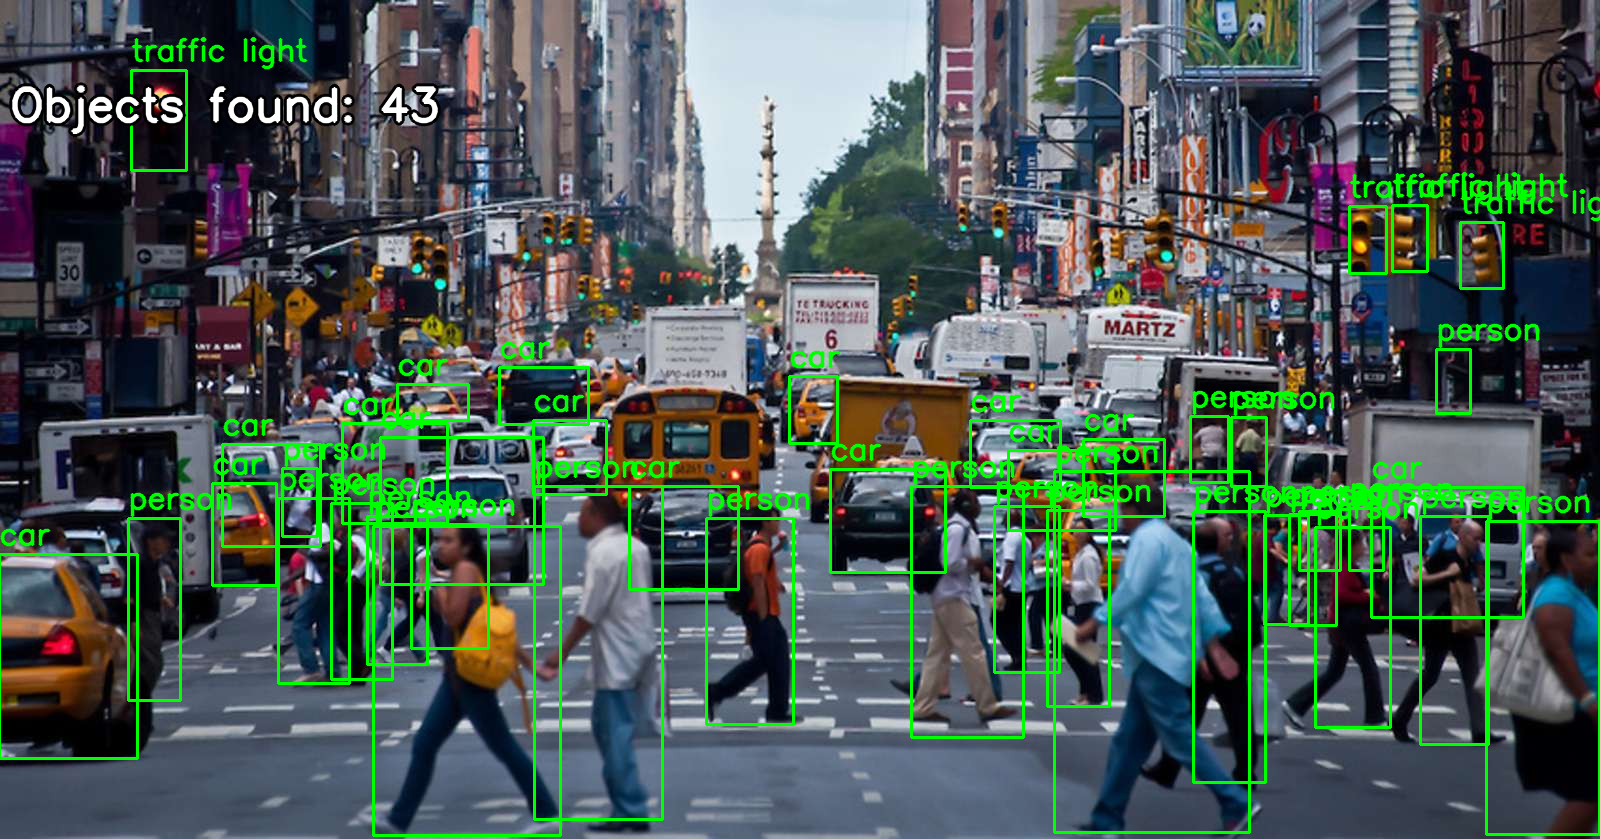

In [ ]:
if __name__ == '__main__':
  	# Loading YOLO scales from files and setting up the network
    net = cv2.dnn.readNetFromDarknet("/content/drive/MyDrive/Help/yolov4-tiny.cfg",
                                     "/content/drive/MyDrive/Help/yolov4-tiny.weights")
    layer_names = net.getLayerNames()
    out_layers_indexes = net.getUnconnectedOutLayers()
    out_layers = [layer_names[index - 1] for index in out_layers_indexes]

    # Loading from a file of object classes that YOLO can detect
    with open("/content/drive/MyDrive/Help/coco.names.txt") as file:
        classes = file.read().split("\n")

    # Determining classes that will be prioritized for search in an image
    # The names are in the file coco.names.txt

    image = input("Path to image(recapcha): ")
    look_for = input("What we are looking for: ").split(',')

    # Delete spaces
    list_look_for = []
    for look in look_for:
        list_look_for.append(look.strip())

    classes_to_look_for = list_look_for

    start_image_object_detection(image)